In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install japanize_matplotlib
! pip install xfeat
! pip install category-encoders

     |████████████████████████████████| 4.1 MB 5.4 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120274 sha256=d99a929b945f97019d2ab84bec6199031d685832d28db501c72db9f769feaf85
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib
     |████████████████████████████████| 302 kB 6.9 MB/s 
     |████████████████████████████████| 80 kB 8.8 MB/s 
     |████████████████████████████████| 208 kB 40.5 MB/s 
     |████████████████████████████████| 75 kB 4.4 MB/s 
     |████████████████████████████████| 49 kB 6.0 MB/s 
     |████████████████████████████████| 144 kB 46.6 MB/s 
     |████████████████████████████████| 111 kB 48.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=289652f6bdf1eabafb0b6d564af2ab326a387d8b8da79442709ced046455afe3
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b0

In [54]:
## import module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from matplotlib_venn import venn2
import os
from statistics import mode
from scipy.optimize import minimize, minimize_scalar
from scipy.misc import derivative

import missingno as msno

from IPython.display import Image

from sklearn.model_selection import KFold, StratifiedKFold
import category_encoders as ce
from xfeat import (SelectCategorical, LabelEncoder, Pipeline, ConcatCombination, SelectNumerical, 
                   ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer)
from sklearn import preprocessing
from time import time
from contextlib import contextmanager
import lightgbm as lgb

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import confusion_matrix

In [4]:
class CFG:
  exp = "exp05"
  seed = 71
  fold = 10

CONFIG = CFG()

In [5]:
input_dir = "/content/drive/MyDrive/KMI_ddbrothers/hirahara/data/"
output_dir = "/content/drive/MyDrive/KMI_ddbrothers/hirahara/output/"

# データフレームの形状変換

In [6]:
pd.set_option("display.max_colwidth", 300)

# Import file
df1 = pd.read_csv(input_dir + "gi_train_mm10.csv")
df2 = pd.read_csv(input_dir + "gi_train_mm11.csv")
df_test = pd.read_csv(input_dir + "gi_test.csv")
item_df = pd.read_csv(output_dir+"item_df.csv",index_col=0)
sample_submit = pd.read_csv(input_dir + "gi_sample_submit.csv")
df_train = pd.concat([df1,df2]).reset_index(drop=True)

df_train = df_train[~df_train.customer_id.isnull()].reset_index()

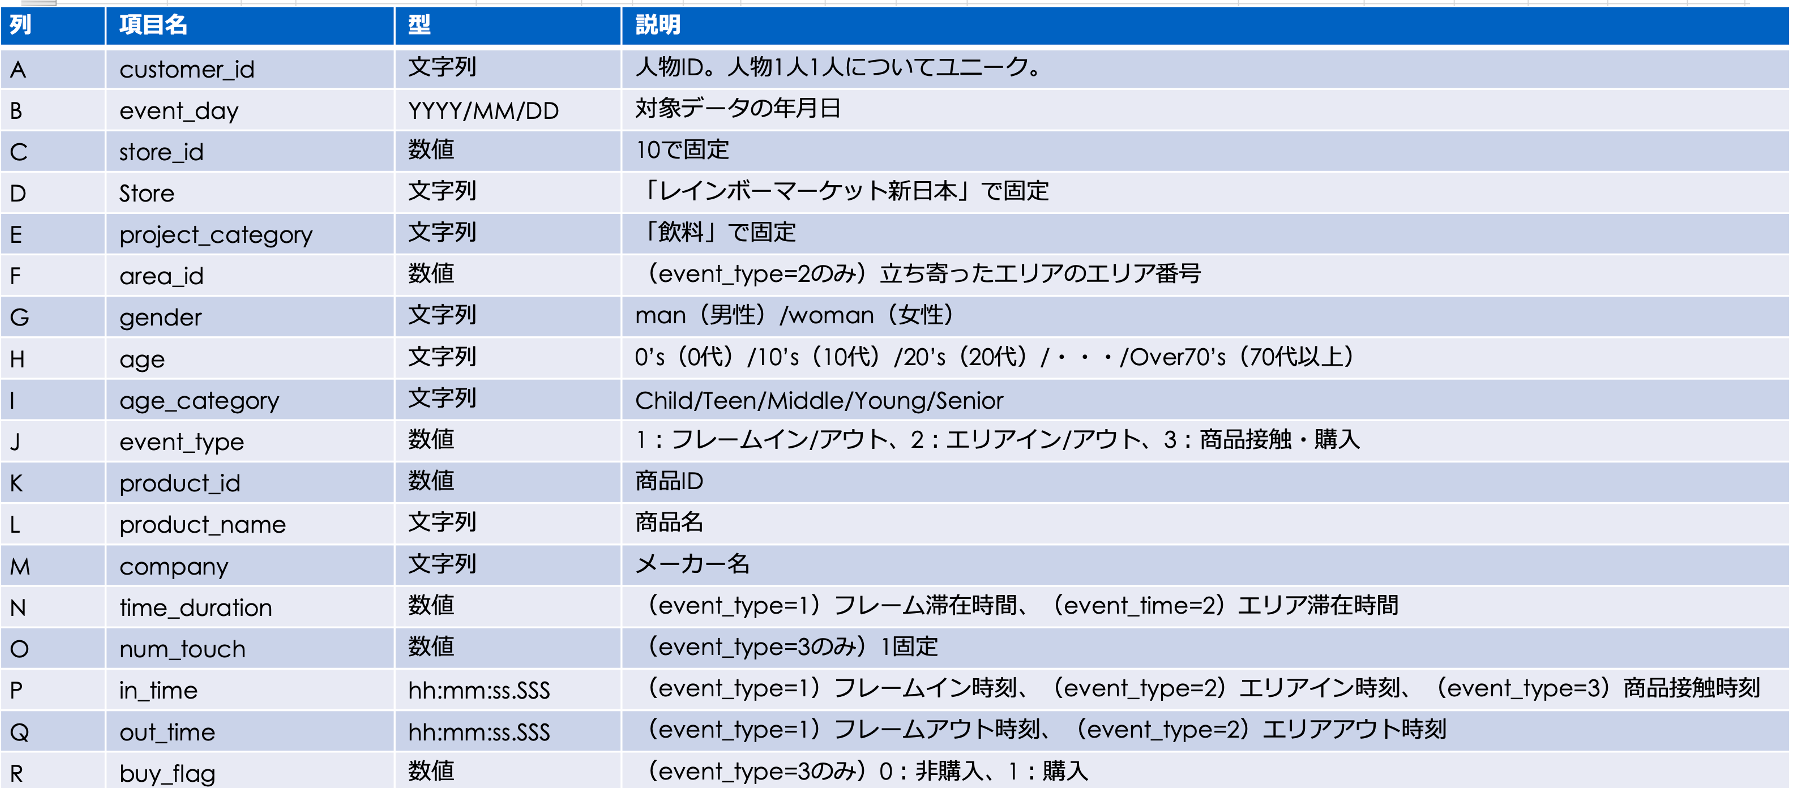

In [626]:
Image(input_dir + "description.png", width = 1000)

In [627]:
df_train.describe()

,index,store_id,area_id,event_type,product_id,time_duration,num_touch,buy_flag
count,20277.000000,20277.0,6480.000000,20277.000000,7002.000000,20277.000000,7002.0,7002.000000
mean,10151.354194,10.0,2.637500,2.010209,50.059840,18.180658,1.0,0.741074
std,5868.043787,0.0,1.439391,0.824837,38.881656,28.341374,0.0,0.438076
min,0.000000,10.0,1.000000,1.000000,1.000000,0.000000,1.0,0.000000
25%,5069.000000,10.0,1.000000,1.000000,17.000000,0.000000,1.0,0.000000
50%,10138.000000,10.0,3.000000,2.000000,41.000000,9.200000,1.0,1.000000
75%,15240.000000,10.0,4.000000,3.000000,83.000000,23.600000,1.0,1.000000
max,20316.000000,10.0,5.000000,3.000000,136.000000,421.600000,1.0,1.000000


In [628]:
sample_submit.shape

(4530, 2)

In [629]:
df_train

,index,customer_id,event_day,store_id,store,project_category,area_id,gender,age,age_category,event_type,product_id,product_name,company,time_duration,num_touch,in_time,out_time,buy_flag
0,0,20201026-010001,2020/10/26,10,レインボーマーケット新日本,飲料,NaN,woman,30's,Young,1,NaN,NaN,NaN,6.2,NaN,08:01:50.200,08:01:56.400,NaN
1,1,20201026-010002,2020/10/26,10,レインボーマーケット新日本,飲料,NaN,man,50's,Middle,1,NaN,NaN,NaN,13.6,NaN,08:02:43.600,08:02:57.200,NaN
2,2,20201026-010003,2020/10/26,10,レインボーマーケット新日本,飲料,NaN,man,50's,Middle,1,NaN,NaN,NaN,14.2,NaN,08:02:57.800,08:03:12.000,NaN
3,3,20201026-010004,2020/10/26,10,レインボーマーケット新日本,飲料,NaN,man,10's,Teen,1,NaN,NaN,NaN,21.0,NaN,08:06:13.200,08:06:34.200,NaN
4,4,20201026-010005,2020/10/26,10,レインボーマーケット新日本,飲料,NaN,woman,30's,Young,1,NaN,NaN,NaN,19.2,NaN,08:07:06.000,08:07:25.200,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20272,20312,20201101-120054,2020/11/1,10,レインボーマーケット新日本,飲料,NaN,man,30's,Young,3,94.0,うるうるグリーンティー525ml,エターナル,0.0,1.0,21:38:20.200,NaN,0.0
20273,20313,20201101-120054,2020/11/1,10,レインボーマーケット新日本,飲料,NaN,man,30's,Young,3,27.0,新緑の丘525ml,フューチャー,0.0,1.0,21:38:20.800,NaN,0.0
20274,20314,20201101-120054,2020/11/1,10,レインボーマーケット新日本,飲料,NaN,man,30's,Young,3,27.0,新緑の丘525ml,フューチャー,0.0,1.0,21:38:21.200,NaN,1.0
20275,20315,20201101-120055,2020/11/1,10,レインボーマーケット新日本,飲料,NaN,woman,30's,Young,3,4.0,ジャパンスプラッシュ500ml,クオリティー,0.0,1.0,21:39:33.800,NaN,0.0


In [630]:
df_train = df_train[['customer_id',
                     'event_day', 
                     #'store_id', 
                     #'store',
                     #'project_category',
                     'area_id',
                     'gender', 
                     'age', 
                     'age_category',
                     'event_type',
                     'product_id', 
                     'product_name', 
                     'company', 
                     'time_duration',
                     'num_touch', 
                     'in_time',
                     'out_time', 
                     'buy_flag']]

df_test = df_test[['customer_id',
                     'event_day', 
                     #'store_id', 
                     #'store',
                     #'project_category',
                     'area_id',
                     'gender', 
                     'age', 
                     'age_category',
                     'event_type',
                     'product_id', 
                     'product_name', 
                     'company', 
                     'time_duration',
                     'num_touch',
                     'in_time',
                     'out_time']]

## データフレームへの時間特徴量の追加

In [631]:
df_train =df_train.copy()
df_test =df_test.copy()

df_train["in_time"]=pd.to_datetime(df_train["in_time"])
df_train["out_time"]=pd.to_datetime(df_train["out_time"])
df_test["in_time"]=pd.to_datetime(df_test["in_time"])
df_test["out_time"]=pd.to_datetime(df_test["out_time"])

In [632]:
#Eventtype=1のin_timeとEventtype=3のin_time
def event1in_time_event3in_time_duration(df,customer_id,datetime):

    df_base3=df[df['customer_id']==customer_id]
    event1=df_base3[df_base3['event_type']==1]
    
    event3_in_time=datetime
    event1_in_time=event1['in_time']
    time_duration=event3_in_time-event1_in_time
    time_duration=time_duration.item().seconds

    return time_duration

In [633]:
#Eventtype=3のin_timeとEventtype=1のout_time差
def event3in_time_event1out_time_duration(df,customer_id,datetime):

    df_base3=df[df['customer_id']==customer_id]
    event1_out_time=df_base3[df_base3['event_type']==1]['out_time']
    
    event3_in_time=datetime
    time_duration=event1_out_time-event3_in_time
    time_duration=time_duration.item().seconds

    return time_duration

In [634]:
df_train['1in_3in']=df_train.apply(lambda x: event1in_time_event3in_time_duration(df_train,x['customer_id'],x['in_time']), axis=1)
df_train['3in_1out']=df_train.apply(lambda x: event3in_time_event1out_time_duration(df_train,x['customer_id'],x['in_time']), axis=1)

df_test['1in_3in']=df_test.apply(lambda x: event1in_time_event3in_time_duration(df_test,x['customer_id'],x['in_time']), axis=1)
df_test['3in_1out']=df_test.apply(lambda x: event3in_time_event1out_time_duration(df_test,x['customer_id'],x['in_time']), axis=1)

KeyboardInterrupt: ignored

In [ ]:
df_train[df_train.customer_id=="20201101-120054"]

In [ ]:
df_train.to_pickle(input_dir + "train_rev.pkl")
df_test.to_pickle(input_dir + "test_rev.pkl")

# 処理済みデータ読み込み

In [7]:
df_train = pd.read_pickle(input_dir + "train_rev.pkl")
df_test = pd.read_pickle(input_dir + "test_rev.pkl")

In [8]:
df_train[df_train["customer_id"]=="20201101-120054"]

,customer_id,event_day,area_id,gender,age,age_category,event_type,product_id,product_name,company,time_duration,num_touch,in_time,out_time,buy_flag,1in_3in,3in_1out
17691,20201101-120054,2020/11/1,NaN,man,30's,Young,1,NaN,NaN,NaN,28.4,NaN,2021-09-19 21:38:07.200,2021-09-19 21:38:35.600,NaN,0,28
18904,20201101-120054,2020/11/1,1.0,man,30's,Young,2,NaN,NaN,NaN,11.2,NaN,2021-09-19 21:38:15.600,2021-09-19 21:38:26.800,NaN,8,20
20272,20201101-120054,2020/11/1,NaN,man,30's,Young,3,94.0,うるうるグリーンティー525ml,エターナル,0.0,1.0,2021-09-19 21:38:20.200,NaT,0.0,13,15
20273,20201101-120054,2020/11/1,NaN,man,30's,Young,3,27.0,新緑の丘525ml,フューチャー,0.0,1.0,2021-09-19 21:38:20.800,NaT,0.0,13,14
20274,20201101-120054,2020/11/1,NaN,man,30's,Young,3,27.0,新緑の丘525ml,フューチャー,0.0,1.0,2021-09-19 21:38:21.200,NaT,1.0,14,14


In [9]:
df_test_0=df_test[df_test.event_type !=3].reset_index(drop=True)

In [10]:
df_train1 = df_train[df_train.event_type ==1].reset_index(drop=True)
df_train2 = df_train[df_train.event_type ==2].reset_index(drop=True)
df_train3 = df_train[df_train.event_type ==3].reset_index(drop=True)

df_test1 = df_test[df_test.event_type ==1].reset_index(drop=True)
df_test2 = df_test[df_test.event_type ==2].reset_index(drop=True)
df_test3 = df_test[df_test.event_type ==3].reset_index(drop=True)

## Customer_IDごとの各特徴量の整理

In [11]:
# base
df_train3 = df_train3.drop(columns=["event_type","product_id","time_duration","num_touch","in_time","out_time","area_id"])
df_test3 = df_test3.drop(columns=["event_type","product_id","time_duration","num_touch","in_time","out_time","area_id"])

#shopper frame time
df_frametime_train=df_train1[["customer_id","time_duration","in_time"]].drop_duplicates()
df_frametime_test=df_test1[["customer_id","time_duration","in_time"]].drop_duplicates()


In [12]:
df_train = pd.merge(df_train3,df_frametime_train,on="customer_id")
df_train = pd.merge(df_train,item_df,on="product_name")
df_train = df_train.reindex(columns=['customer_id', 'event_day', 'gender', 'age', 'age_category','product_name', 'company', 'area_id', '1in_3in', '3in_1out','time_duration', 'in_time', 'buy_flag'])

df_test = pd.merge(df_test3,df_frametime_train,on="customer_id")
df_test = pd.merge(df_test,item_df,on="product_name")
df_test = df_test.reindex(columns=['customer_id', 'event_day', 'gender', 'age', 'age_category','product_name', 'company', 'area_id', '1in_3in', '3in_1out','time_duration', 'in_time'])

In [13]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,company,area_id,1in_3in,3in_1out,time_duration,in_time,buy_flag
0,20201026-010001,2020/10/26,woman,30's,Young,トラディショナル緑茶525ml,クオリティー,1.0,1,5,6.2,2021-09-19 08:01:50.200,1.0
1,20201026-010001,2020/10/26,woman,30's,Young,トラディショナル緑茶525ml,クオリティー,1.0,3,2,6.2,2021-09-19 08:01:50.200,1.0
2,20201026-010002,2020/10/26,man,50's,Middle,トラディショナル緑茶525ml,クオリティー,1.0,10,3,13.6,2021-09-19 08:02:43.600,1.0
3,20201026-010017,2020/10/26,man,30's,Young,トラディショナル緑茶525ml,クオリティー,1.0,8,49,58.4,2021-09-19 08:19:15.000,0.0
4,20201026-010017,2020/10/26,man,30's,Young,トラディショナル緑茶525ml,クオリティー,1.0,10,48,58.4,2021-09-19 08:19:15.000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6997,20201101-090008,2020/11/1,man,30's,Young,本当のオレンジ490ml,フューチャー,3.0,22,101,124.0,2021-09-19 17:02:30.400,0.0
6998,20201101-100059,2020/11/1,man,60's,Senior,本当のオレンジ490ml,フューチャー,3.0,85,61,146.6,2021-09-19 18:21:02.200,1.0
6999,20201101-110130,2020/11/1,man,30's,Young,本当のオレンジ490ml,フューチャー,3.0,11,31,43.0,2021-09-19 20:27:12.200,0.0
7000,20201101-110130,2020/11/1,man,30's,Young,本当のオレンジ490ml,フューチャー,3.0,28,15,43.0,2021-09-19 20:27:12.200,0.0


In [14]:
df_train[df_train["customer_id"]=="20201101-120054"]

,customer_id,event_day,gender,age,age_category,product_name,company,area_id,1in_3in,3in_1out,time_duration,in_time,buy_flag
2850,20201101-120054,2020/11/1,man,30's,Young,新緑の丘525ml,フューチャー,1.0,13,14,28.4,2021-09-19 21:38:07.200,0.0
2851,20201101-120054,2020/11/1,man,30's,Young,新緑の丘525ml,フューチャー,1.0,14,14,28.4,2021-09-19 21:38:07.200,1.0
3206,20201101-120054,2020/11/1,man,30's,Young,うるうるグリーンティー525ml,エターナル,1.0,13,15,28.4,2021-09-19 21:38:07.200,0.0


In [15]:
df_train.buy_flag.value_counts()

1.0    5189
0.0    1813
Name: buy_flag, dtype: int64

In [16]:
df_train.area_id.value_counts()

1.0    2850
3.0    1673
5.0    1121
2.0     835
4.0     523
Name: area_id, dtype: int64

# 前処理

## 容量のカラム追加

In [17]:
size_train=df_train.product_name.str.extract(r'(\d\d\d)').astype(int)
df_train.insert(loc = 6, column= 'size', value= size_train)

size_test=df_test.product_name.str.extract(r'(\d\d\d)').astype(int)
df_test.insert(loc = 6, column= 'size', value= size_test)

In [18]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration,in_time,buy_flag
0,20201026-010001,2020/10/26,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,1,5,6.2,2021-09-19 08:01:50.200,1.0
1,20201026-010001,2020/10/26,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,3,2,6.2,2021-09-19 08:01:50.200,1.0
2,20201026-010002,2020/10/26,man,50's,Middle,トラディショナル緑茶525ml,525,クオリティー,1.0,10,3,13.6,2021-09-19 08:02:43.600,1.0
3,20201026-010017,2020/10/26,man,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,8,49,58.4,2021-09-19 08:19:15.000,0.0
4,20201026-010017,2020/10/26,man,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,10,48,58.4,2021-09-19 08:19:15.000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6997,20201101-090008,2020/11/1,man,30's,Young,本当のオレンジ490ml,490,フューチャー,3.0,22,101,124.0,2021-09-19 17:02:30.400,0.0
6998,20201101-100059,2020/11/1,man,60's,Senior,本当のオレンジ490ml,490,フューチャー,3.0,85,61,146.6,2021-09-19 18:21:02.200,1.0
6999,20201101-110130,2020/11/1,man,30's,Young,本当のオレンジ490ml,490,フューチャー,3.0,11,31,43.0,2021-09-19 20:27:12.200,0.0
7000,20201101-110130,2020/11/1,man,30's,Young,本当のオレンジ490ml,490,フューチャー,3.0,28,15,43.0,2021-09-19 20:27:12.200,0.0


## 入時間の設定

In [19]:
#エントリータイムの時間を抽出
df_train["in_time"] = pd.to_datetime(df_train["in_time"])
df_train["in_time"] = df_train["in_time"].apply(lambda x: x.hour)
df_train["in_time"] =df_train["in_time"].astype("object")

df_test["in_time"] = pd.to_datetime(df_test["in_time"])
df_test["in_time"] = df_test["in_time"].apply(lambda x: x.hour)
df_test["in_time"] =df_test["in_time"].astype("object")

#曜日
df_train["event_day"] = pd.to_datetime(df_train["event_day"])
df_train["event_day"] = df_train["event_day"].apply(lambda x: x.weekday())
df_train["event_day"] =df_train["event_day"].astype("object")

df_test["event_day"] = pd.to_datetime(df_test["event_day"])
df_test["event_day"] = df_test["event_day"].apply(lambda x: x.weekday())
df_test["event_day"] =df_test["event_day"].astype("object")

In [20]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration,in_time,buy_flag
0,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,1,5,6.2,8,1.0
1,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,3,2,6.2,8,1.0
2,20201026-010002,0,man,50's,Middle,トラディショナル緑茶525ml,525,クオリティー,1.0,10,3,13.6,8,1.0
3,20201026-010017,0,man,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,8,49,58.4,8,0.0
4,20201026-010017,0,man,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,10,48,58.4,8,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6997,20201101-090008,6,man,30's,Young,本当のオレンジ490ml,490,フューチャー,3.0,22,101,124.0,17,0.0
6998,20201101-100059,6,man,60's,Senior,本当のオレンジ490ml,490,フューチャー,3.0,85,61,146.6,18,1.0
6999,20201101-110130,6,man,30's,Young,本当のオレンジ490ml,490,フューチャー,3.0,11,31,43.0,20,0.0
7000,20201101-110130,6,man,30's,Young,本当のオレンジ490ml,490,フューチャー,3.0,28,15,43.0,20,0.0


## カテゴリカルエンコーディング

In [21]:
# BaseBlock
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)
    
    def transform(self, input_df):
        raise NotImplementedError()
        
# CountEncoding
class CountEncodingBlock(BaseBlock):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None
        
    def fit(self, input_df, y=None):
        return self.transform(input_df[self.cols])
    
    def transform(self, input_df):
        self.encoder = ce.CountEncoder()
        self.encoder.fit(input_df[self.cols])
        return self.encoder.transform(input_df[self.cols]).add_prefix("CE_")

# OneHotEncoding
class OneHotEncodingBlock(BaseBlock):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None
        
    def fit(self, input_df, y=None):
        self.encoder = ce.OneHotEncoder(use_cat_names=True)
        self.encoder.fit(input_df[self.cols])
        return self.transform(input_df[self.cols])
    
    def transform(self, input_df):
        return self.encoder.transform(input_df[self.cols]).add_prefix("OHE_")

# OrdinalEncoding
class OrdinalEncodingBlock(BaseBlock):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None
        
    def fit(self, input_df, y=None):
        self.encoder = ce.OrdinalEncoder()
        self.encoder.fit(input_df[self.cols])
        return self.transform(input_df[self.cols])
    
    def transform(self, input_df):
        return self.encoder.transform(input_df[self.cols]).add_prefix("OE_")

In [22]:
def get_ce_features(input_df):
    _input_df = pd.concat([input_df], axis=1)
    
    cols = ['gender',
            'age',
            'age_category', 
            'event_day', 
            'area_id',
            'in_time',
            'product_name', 
            'size', 
            'company']
    encoder = CountEncodingBlock(cols = cols)
    output_df = encoder.fit(_input_df.astype(str))
    return output_df


def get_oe_features(input_df):
    _input_df = pd.concat([input_df], axis=1)
    cols = ['gender',
            'age',
            'age_category', 
            'event_day', 
            'area_id',
            'in_time',
            'product_name', 
            'size', 
            'company']
    encoder = OrdinalEncodingBlock(cols = cols)
    output_df = encoder.fit(_input_df)
    return output_df

# not use
def get_ohe_features(input_df):
    _input_df = pd.concat([input_df], axis=1)
    cols = ['gender',
            'age',
            'age_category', 
            'event_day', 
            'area_id',
            'in_time',
            'product_name', 
            'size', 
            'company']
    encoder = OneHotEncodingBlock(cols=cols)
    output_df = encoder.fit(_input_df)
    return output_df

In [23]:
df_train_ce=get_ce_features(df_train)
df_train_oe=get_oe_features(df_train)

df_test_ce=get_ce_features(df_test)
df_test_oe=get_oe_features(df_test)

In [24]:
target = df_train["buy_flag"]
df_train_encoded = df_train.drop(columns=["customer_id",'gender','age','age_category', 'event_day', 'area_id','in_time','product_name', 'size', 'company',"buy_flag"])
df_train_encoded = pd.concat([df_train_encoded,df_train_ce,df_train_oe],axis=1)
df_train_encoded["buy_flag"] = target 

df_test_encoded = df_test.drop(columns=['gender','age','age_category', 'event_day', 'area_id','in_time','product_name', 'size', 'company'])
df_test_encoded = pd.concat([df_test_encoded,df_test_ce,df_train_oe],axis=1)

In [25]:
df_train_encoded

,1in_3in,3in_1out,time_duration,CE_gender,CE_age,CE_age_category,CE_event_day,CE_area_id,CE_in_time,CE_product_name,CE_size,CE_company,OE_gender,OE_age,OE_age_category,OE_event_day,OE_area_id,OE_in_time,OE_product_name,OE_size,OE_company,buy_flag
0,1,5,6.2,3741,1335,1806,850,2850,328,270,1389,1280,1,1,1,1,1.0,1,1,525,1,1.0
1,3,2,6.2,3741,1335,1806,850,2850,328,270,1389,1280,1,1,1,1,1.0,1,1,525,1,1.0
2,10,3,13.6,3261,1559,3270,850,2850,328,270,1389,1280,2,2,2,1,1.0,1,1,525,1,1.0
3,8,49,58.4,3261,1335,1806,850,2850,328,270,1389,1280,2,1,1,1,1.0,1,1,525,1,0.0
4,10,48,58.4,3261,1335,1806,850,2850,328,270,1389,1280,2,1,1,1,1.0,1,1,525,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6997,22,101,124.0,3261,1335,1806,1370,1673,612,19,223,1759,2,1,1,7,3.0,13,136,490,2,0.0
6998,85,61,146.6,3261,941,1175,1370,1673,758,19,223,1759,2,3,3,7,3.0,9,136,490,2,1.0
6999,11,31,43.0,3261,1335,1806,1370,1673,387,19,223,1759,2,1,1,7,3.0,11,136,490,2,0.0
7000,28,15,43.0,3261,1335,1806,1370,1673,387,19,223,1759,2,1,1,7,3.0,11,136,490,2,0.0


In [26]:
df_train_encoded.to_pickle(input_dir + "train_enco.pkl")
df_test_encoded.to_pickle(input_dir + "test_enco.pkl")

# モデル作成　(Light GBM)

In [27]:
@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [49]:
def opt_auc_threshold(y_true, y_pred):
  """auc score計算時のthresholdを最適化"""
  def opt_(x):
    return -roc_auc_score(y_true, y_pred >= x)
  result = minimize(opt_, x0=np.array([0.5]))
  best_threshold = result['x'].item()
  return best_threshold

In [79]:
def focal_loss_lgb_sk(y_true, y_pred, alpha, gamma, num_class=2):
    a,g = alpha, gamma
    y_true = np.eye(num_class)[y_true.astype('int')]
    y_pred = y_pred.reshape(-1, num_class, order='F')
    def fl(x,t):
        p = 1/(1+np.exp(-x))
        return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
    partial_fl = lambda x: fl(x, y_true)
    grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
    hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
    return  grad.flatten('F'), hess.flatten('F')

def focal_loss_lgb_eval_error_sk(y_true, y_pred, alpha, gamma, num_class=2):
    a,g = alpha, gamma
    y_true = np.eye(num_class)[y_true.astype('int')]
    y_pred = y_pred.reshape(-1, num_class, order='F')
    p = 1/(1+np.exp(-y_pred))
    loss = -( a*y_true + (1-a)*(1-y_true) ) * (( 1 - ( y_true*p + (1-y_true)*(1-p)) )**g) * ( y_true*np.log(p)+(1-y_true)*np.log(1-p) )
    return 'focal_loss', np.mean(loss), False

focal_loss = lambda x,y: focal_loss_lgb_sk(x, y, 0.25, 2)
eval_error = lambda x,y: focal_loss_lgb_eval_error_sk(x, y, 0.25, 2)

In [80]:
def fit_lgbm(X, y, cv, params: dict=None, verbose: int=100):
    
    metric_func = roc_auc_score
    #metrics_func_sub = accuracy_score
    
    if params is None:
        params = {}

    models = []
    best_borders=[]
    
    # training data の target と同じだけのゼロ配列を用意
    oof_pred_df = pd.DataFrame()

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # 交差検証 データセットを cv instance によって分割
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgb.LGBMClassifier(**params)

        # auc_score用のborder算出(単純にデータ数で閾値を決定）
        #border = y_valid.sum() / len(x_valid)
        #border = 0.5

        with timer(prefix='fit fold={} '.format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=verbose,
                    verbose=verbose,
                    eval_metric=eval_error)
        
        # border で1, 0を分離するので、確率で算出する

        pred_i = clf.predict_proba(x_valid)[:, 1]
        pred_b = clf.predict(x_valid)

        border_m = opt_auc_threshold(y_valid, pred_b)
        best_borders.append(border_m)

        print(f"Best_Score_Border： {border_m}")

        pred_b = np.where(pred_i < border_m, 0, 1)
        print(f'AUC {i} Score: {metric_func(y_valid, pred_b) :.4f}')
        #print(f'Accuracy {i} Score: {metrics_func_sub(y_valid, pred_b) :.4f}')
        
        oof_fold_df = pd.DataFrame(np.zeros_like(y_valid, dtype=np.float)).rename(columns={0:"pred"})
        oof_fold_df["id"]=idx_valid
        oof_fold_df["fold"]=i+1
        oof_fold_df["pred_prob"] = pred_i
        oof_fold_df["pred_bool"] = pred_b
        
        oof_pred_df=pd.concat([oof_pred_df,oof_fold_df],axis=0)
        
        
        models.append(clf)
        
    oof_pred_df=oof_pred_df.sort_values("id").reset_index(drop=True).set_index("id").reindex(['fold', 'y', 'pred_prob','pred_bool'], axis='columns')
    oof_pred_df["y"]=y
    score = metric_func(y, oof_pred_df["pred_prob"]) 
    print('FINISHED | AUC Score: {:.4f}'.format(score))
    return oof_pred_df, models

## 学習

In [81]:
params = {
    'learning_rate': 0.01,
    'n_estimators': 10000,
    'objective': focal_loss,
    'class_weight':"balanced",
    'max_depth': 5,
    #"early_stopping_rounds": 100,
    "random_state":71
    }

fold = StratifiedKFold(n_splits=CONFIG.fold, shuffle=True, random_state=CONFIG.seed)
cv = list(fold.split(df_train_encoded, df_train_encoded["buy_flag"]))

train_x = df_train_encoded.iloc[:,:-1]
train_y = df_train_encoded["buy_flag"]


oof, models = fit_lgbm(train_x.values, train_y, cv, params=None)

IndexError: ignored

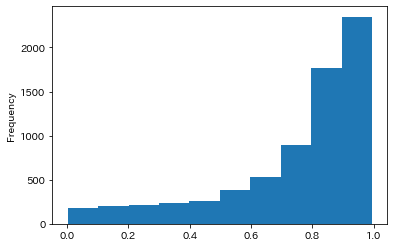

In [75]:
oof["pred_prob"].plot(kind="hist")

## 学習結果

In [689]:
#特徴量の可視化
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現する.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(10, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='Blues_d', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    
    return fig, ax

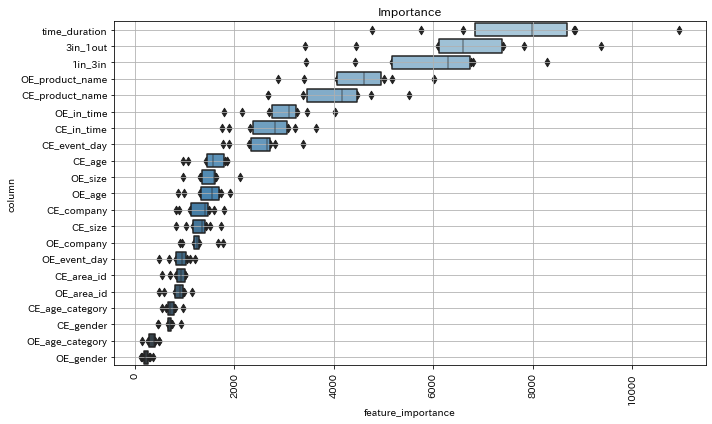

In [690]:
fig, ax = visualize_importance(models, train_x)

In [691]:
#ROCカーブの可視化
def visulalize_roc(df, fold):
    """各foldおよび出力平均のROCカーブを描画する

    args:
        df:出力oof df
        fold: fold数
    """
    
    fig = plt.figure(figsize=[8,8])
    
    tprs = []
    aucs = []
    
    mean_fpr = np.linspace(0,1,100)
    
    i = 1
    
    folds = list(range(1,fold+1))
    

    for v in folds:
        
        df_tmp = df[df.fold==v]
        fpr, tpr, t = roc_curve(df_tmp["y"], df_tmp["pred_prob"])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.3f)' % (i, roc_auc))
        i= i+1

    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='blue',
             label=r'Mean ROC (AUC = %0.3f )' % (mean_auc),lw=2, alpha=1)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")

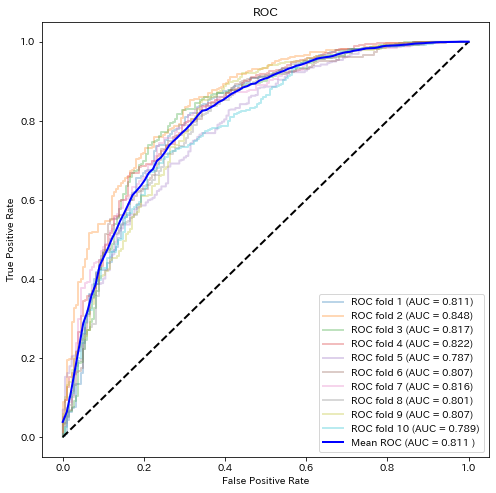

In [692]:
visulalize_roc(oof,CONFIG.fold)

In [ ]:
#混合行列の可視化
def visualize_confusion_matrix(y_true,pred_label,height=.6,labels=None):
    
    """
    混合行列をプロットする
    """
    
    conf = confusion_matrix(y_true=y_true,
                            y_pred=pred_label,
                            normalize='true')

    n_labels = len(conf)
    size = n_labels * height
    fig, ax = plt.subplots(figsize=(size * 4, size * 3))
    sns.heatmap(conf, cmap='Blues', ax=ax, annot=True, fmt='.2f')
    ax.set_ylabel('Label')
    ax.set_xlabel('Predict')

    if labels is not None:
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.tick_params('y', labelrotation=0)
        ax.tick_params('x', labelrotation=90)

In [ ]:
visualize_confusion_matrix(y_true=oof.y,pred_label=oof.pred_bool)

## 予測

In [ ]:
df_index = df_test_encoded["customer_id"]
df_test_pred = df_test_encoded.iloc[:,1:]

pred = np.array([model.predict(df_test_pred.values) for model in models])
pred = np.mean(pred, axis=0)

In [ ]:
submission_pred = pd.DataFrame()
submission_pred["customer_id"] = df_index
submission_pred["buy_proba"] = pred

In [ ]:
submission_pred

In [ ]:
submission_pred_0 = pd.DataFrame()
submission_pred_0["customer_id"] = df_test_0["index"]
submission_pred_0["buy_proba"] = 0

In [ ]:
submission_pred_0

In [ ]:
submission_pred_all = pd.concat([submission_pred,submission_pred_0],axis=0).sort_values("customer_id").reset_index(drop=True)

In [ ]:
submission_pred_all

In [ ]:
submission_pred_all.to_csv(output_dir + CONFIG.exp+ "_submission.csv",index=False)